# Trend Scanning Method
## BOOK Machine Learning for Asset Managers by Marcos Lopez de Prado
https://www.amazon.com.br/Machine-Learning-Asset-Managers-Marcos/dp/1108792898

In [5]:
# -*- coding: utf-8 -*-
import statsmodels.api as sm1
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import yfinance as yf
    
#Trend scanning method

#code snippet 5.1
# Fit linear regression on close
# Return the t-statistic for a given parameter estimate.
def tValLinR(close):
    #tValue from a linear trend
    x = np.ones((close.shape[0],2))
    x[:,1] = np.arange(close.shape[0])
    ols = sm1.OLS(close, x).fit()
    return ols.tvalues[1]
    
#code snippet 5.2
'''
    - molecule - index of observations we wish to labels. 
    - close - which is the time series of x_t
    - span - is the set of values of L (look forward period) that the algorithm will try.
    The L that maximizes |tHat_B_1| is choosen - which is the look-forward period 
    with the most significant trend.
'''
def getBinsFromTrend(molecule, close, span):
    '''
    Derive labels from the sign of t-value of trend line
    output includes:
      - t1: End time for the identified trend
      - tVal: t-value associated with the estimated trend coefficient
      - bin: Sign of the trend
    The t-statistics for each tick has a different look-back window.
      
    - dt0 start time in look-forward window
    - dt1 stop time in look-forward window
    - df1 is the look-forward window
    - iloc ? 
    '''
    out = pd.DataFrame(index=molecule, columns=['t1', 'tVal', 'bin'])
    hrzns = range(*span)
    print(hrzns)
    for dt0 in molecule:
        df0 = pd.Series(dtype='float64')
        iloc0 = close.index.get_loc(dt0)
        if iloc0+max(hrzns) > close.shape[0]:
            continue
        for hrzn in hrzns:
            dt1 = close.index[iloc0+hrzn-1]
            df1 = close.loc[dt0:dt1]
            df0.loc[dt1] = tValLinR(df1.values)
        dt1=df0.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
        out.loc[dt0, ['t1', 'tVal', 'bin']] = df0.index[-1], df0[dt1], np.sign(df0[dt1]) #prevent leakage
    out['t1'] = pd.to_datetime(out['t1'])
    out['bin'] = pd.to_numeric(out['bin'], downcast='signed')
    return out.dropna(subset=['bin'])

def get_data(symbol, begin_date=None,end_date=None):
    df = yf.download(symbol, start = begin_date,auto_adjust=True,end= end_date)  #only download adjusted data
    #my convention: always lowercase
    df.columns = ['open','high','low','close','volume'] 
    return df



[*********************100%***********************]  1 of 1 completed
range(3, 10)


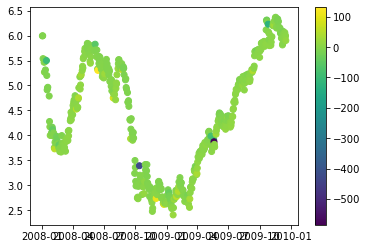

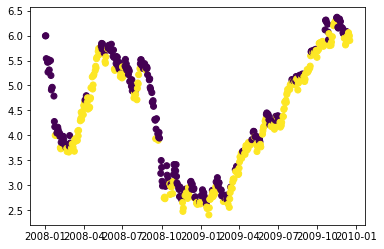

In [9]:
#snippet 5.3
Apple_stock = get_data('AAPL', '2008-01-01', '2009-12-31')   
price = Apple_stock['close']

#df0 = pd.Series(np.random.normal(0, .1, 100)).cumsum()
#df0 += np.sin(np.linspace(0, 10, df0.shape[0]))
#df1 = getBinsFromTrend(df0.index, df0, [3,10,1]) #[3,10,1] = range(3,10)

df1 = getBinsFromTrend(price.index, price, [3,10,1]) #[3,10,1] = range(3,10)
tValues = df1['tVal'].values

doNormalize = False
#normalise t-values to -1, 1
if doNormalize: 
    np.min(tValues)
    minusArgs = [i for i in range(0, len(tValues)) if tValues[i] < 0]
    tValues[minusArgs] = tValues[minusArgs] / (np.min(tValues)*(-1.0))

    plus_one = [i for i in range(0, len(tValues)) if tValues[i] > 0]
    tValues[plus_one] = tValues[plus_one] / np.max(tValues)


#plt.scatter(df1.index, df0.loc[df1.index].values, c=tValues, cmap='viridis') #df1['tVal'].values, cmap='viridis')
plt.scatter(df1.index, price.loc[df1.index].values, c=tValues, cmap='viridis') #df1['tVal'].values, cmap='viridis')
plt.colorbar()
plt.show()
plt.savefig('fig5.2.png')
plt.clf()
plt.close()
#plt.scatter(df1.index, df0.loc[df1.index].values, c=df1['bin'].values, cmap='viridis')
plt.scatter(df1.index, price.loc[df1.index].values, c=df1['bin'].values, cmap='viridis')

#Test methods
ols_tvalue = tValLinR( np.array([3.0, 3.5, 4.0]) )